In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import OrderedDict

# model
import lightgbm as lgb
from sklearn.svm import SVR

# optz
from sklearn.datasets import make_blobs
from skopt.searchcv import BayesSearchCV
from skopt.space import Categorical, Real, Integer

# preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import KFold, train_test_split

# metrics 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
 

In [2]:
train = pd.read_csv('../train.csv')
test = pd.read_csv('../test.csv')

In [3]:
# fillna 
train.MasVnrArea = train.MasVnrArea.fillna(0)
train.MasVnrType = train.MasVnrType.fillna('CBlock')
train.LotFrontage = train.LotFrontage.fillna(train.LotFrontage.median())
train.GarageYrBlt = train.GarageYrBlt.fillna(1900).astype(int).astype('category').cat.codes

In [4]:
cols = train.loc[:, train.isna().any()].columns.to_list()
train[cols] = train[cols].apply(lambda x: x.fillna('NA'))

In [5]:
y = train.SalePrice.astype(int)
X = train.drop(['SalePrice', 'Id'], axis=1)

In [6]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,NA,NA,NA,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,NA,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,0,NA,NA,NA,0,12,2008,WD,Normal


In [7]:
# type_int = ['int16', 'int32', 'int64']
# col_int = [i for i in X if X[i].dtypes in type_int]

# type_flt = ['float16', 'float32', 'float64']
# col_flt = [i for i in X if X[i].dtypes in type_flt]

# col_cat = [i for i in X if X[i].dtypes not in type_flt and X[i].dtypes not in type_int]

In [8]:
cols = [
    'PoolArea',
    'ScreenPorch', 
    '3SsnPorch', 
    'EnclosedPorch', 
    'OpenPorchSF' ,
    'WoodDeckSF',
    'GarageArea', 
    'LotArea',
    'LotFrontage']
 
X[cols] = X[cols].astype(int)


In [9]:
# meong = pd.get_dummies(X)
# meong = meong.apply(pd.to_numeric, errors='coerce')

In [10]:
cat = [X[i].astype('category').cat.codes for i in X.columns]
cat = pd.DataFrame(cat).transpose()
cat.columns = X.columns

In [11]:
ordered_rank_features = SelectKBest(score_func=chi2, k=14)
ordered_feature = ordered_rank_features.fit(cat, y)

In [12]:
df_scores = pd.DataFrame(ordered_feature.scores_, columns=['Score'])
df_columns = pd.DataFrame(cat.columns)
univariate_ranked = pd.concat([df_columns, df_scores],axis=1)
univariate_ranked.columns = ['Features', 'Scores']
univariate_ranked.set_index('Features', inplace = True)

In [13]:
# top 15 feature
top_cat = univariate_ranked.sort_values('Scores', ascending = False)

In [14]:
train_x, test_x, train_y, test_y = train_test_split(cat[top_cat.index.tolist()], y, test_size=0.3, random_state=1)

In [15]:
lg_search = {
    'max_depth': Integer(1, 10),
    'bagging_freq': Integer(1, 40), 
    'bagging_fraction': Real(0.5, 0.99),
    'n_estimators': Integer(50, 1000),
    'learning_rate': Real(0.0001, 0.1),
    'metric': ['rmse'],
    'boosting_type': Categorical(['dart', 'gbdt', 'rf']), 
    'objective': Categorical(['regression_l1', 'regression_l2', 'regression']),
  }

In [16]:
svr_search = {
    'kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'degree': Integer(1, 100),
    'gamma': Categorical(['scale', 'auto']),
    # 'coef0': Real(0.001, 0.1),
    'C': Real(1.0, 10.0),
    'epsilon': Real(0.001, 0.1),
    'shrinking': Categorical(['True', 'False']),
    'verbose': Categorical(['True', 'False']),
    'max_iter': Integer(1, 10)
}

In [17]:
# hyperparameter selection
# %%time

# model = SVR()
# model.fit(train_x, train_y)


# cv = KFold(n_splits=5)
# opt = BayesSearchCV(model, svr_search, cv=cv)
# opt.fit(train_x.values, train_y.values)

In [18]:
# cv_results = pd.DataFrame(opt.cv_results_)
# cv_results.to_csv('../params.csv')

In [19]:
# params = pd.read_csv('../params.csv')
# params.sort_values(by='rank_test_score', ascending=False)

In [20]:
lgb_pars = {
    'bagging_fraction': 0.99,
    'bagging_freq': 7,
    'boosting_type': 'gbdt',
    'learning_rate': 0.0797248658591012,
    'max_depth': 10,
    'metric': 'rmse',
    'n_estimators': 50,
    'objective': 'regression_l1'}

In [21]:
svr_pars = {
    'kernel': 'linear',
    # 'degree': 45,
    'gamma': 'scale',
    'coef0': 0.01,
    'C': 0.1,
    'epsilon': 0.01,
    'shrinking': False,
    'verbose': False,
    'max_iter': 1000
}

In [22]:
class Prediction:
    def __init__(self, train_x, test_x, train_y, test_y):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y

    def lgbm(self, params):
        model  = lgb.LGBMRegressor(**params)
        model.fit(self.train_x, self.train_y)
        prediction = model.predict(self.test_x)

        return prediction

    def svr(self, params):
        model = SVR(**params)
        model.fit(self.train_x, self.train_y)
        prediction = model.predict(self.test_x)

        return prediction

    def acc(self, y_pred):
        medae  = median_absolute_error(self.test_y, y_pred, multioutput='raw_values')
        mae = mean_absolute_error(self.test_y, y_pred, multioutput='raw_values')
        rmse = mean_squared_error(self.test_y, y_pred, squared=False)
        r2 = r2_score(self.test_y, y_pred)
        
        return medae, rmse, mae, r2

    def plot_result(self, prediction):
        plt.figure(figsize = (10,10))
        plt.scatter(prediction, self.test_y, color = 'r', s = 5)
        plt.xlabel('Prediction')
        plt.ylabel('Actual')
        plt.plot([0,3e6], [0,3e6])
        plt.title("Airbnb Forecast vs Actual")
        plt.show()

In [23]:
predict = Prediction(train_x, test_x, train_y, test_y)

In [24]:
pred = pd.DataFrame(predict.lgbm(lgb_pars), columns=['lgbm'])

[LightGBM] [Warning] bagging_fraction is set=0.99, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [25]:
pred['svr'] = predict.svr(svr_pars)

c:\Users\ACER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [26]:
pred['actual'] = test_y.reset_index(drop=True)

In [27]:
medae, rmse, mae, r2 = predict.acc(pred.lgbm)
print('Test MedAE: %.8f' % medae)
print('Test MAE: %.8f' % mae)
print('Test RMSE: %.8f' % rmse)
print('Test R2: %.8f' % r2)
print('\n')

Test MedAE: 11540.77904998
Test MAE: 18592.96914534
Test RMSE: 33167.21204205
Test R2: 0.84593595




In [28]:
medae, rmse, mae, r2 = predict.acc(pred.svr)
print('Test MedAE: %.8f' % medae)
print('Test MAE: %.8f' % mae)
print('Test RMSE: %.8f' % rmse)
print('Test R2: %.8f' % r2)
print('\n')

Test MedAE: 15326.17596761
Test MAE: 25633.69716752
Test RMSE: 43584.37356067
Test R2: 0.73396120




In [29]:
# predict.plot_result(pred.lgbm)

<AxesSubplot:>

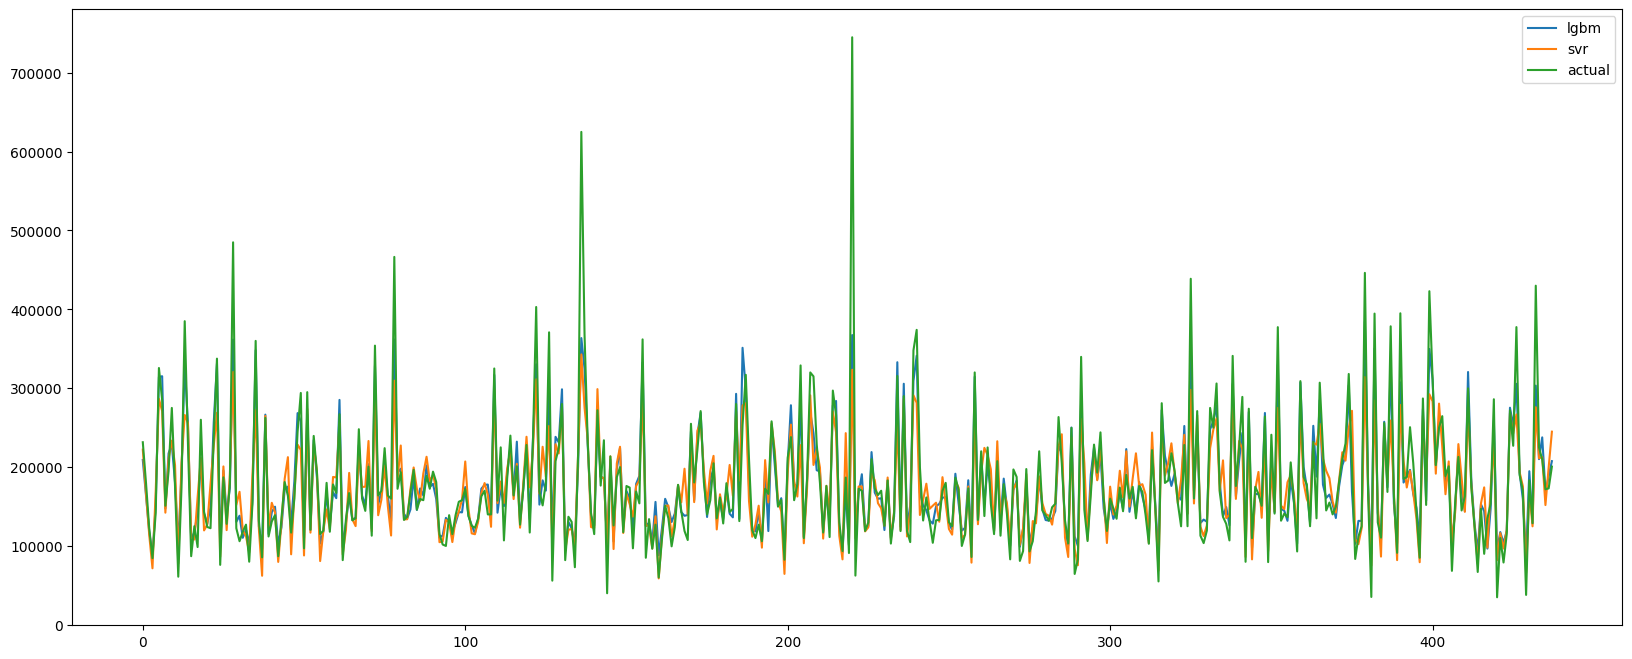

In [30]:
pred.plot(figsize=(20, 8))